<a href="https://colab.research.google.com/github/SupradeepDanturti/Understanding-SpeechBrain/blob/main/Prepare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install speechbrain

In [ ]:
import os
import json
import glob
import torch
import shutil
import random
import librosa
import torchaudio
import numpy as np
import pandas as pd
import speechbrain as sb
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
from speechbrain.lobes.augment import _prepare_openrir, EnvCorrupt

In [ ]:
%cd /content/

/content


In [ ]:
%%capture
# # !gdown 1HYmz81UgfOBXC5QahfPtTq6T7NvTwTVt #trainclean100

from google.colab import drive
drive.mount('/content/drive/')

# !tar -xvzf /content/drive/MyDrive/ConvAI/Project/train-clean-100.tar.gz # Complete Dataset

!tar -xvzf /content/drive/MyDrive/ConvAI/Project/miniLibriSpeech.tar.gz # Mini Dataset

In [ ]:
libri_root_path = "/content/miniLibriSpeech/"
librispeech_csv = "/content/librispeech.csv"

miniLibriSpeechSegments_path = "/content/miniLibriSpeechSegments/"

output_folder_corruptednoises = "/content/corruptednoises/"
corruptednoises_csv = '/content/corruptednoises.csv'

openrir_folder = "/content/"
reverb_csv = "reverb.csv"
noise_csv = "noise.csv"
max_noise_len = 10.0

# Noise and Reverb

In [ ]:
def parse_to_csv(path, csv_filename):
  """ Iterate directory to csv
   Arguments
    ---------
    path : str
        The folder relative to which the files in the list are listed.
    csv_filename : str
        The location to use for writing the csv file.
  """
  flac_files = glob.glob(os.path.join(path, f"**/*.flac"), recursive=True)
  txt_files = glob.glob(os.path.join(path, "**/*.txt"), recursive=True)

  # Dictionary to store parsed data
  data = {
      "ID": [],
      "file_path": [],
      "words": [],
      "spkID": [],
      "duration": []
  }

  # Extract transcript information
  words_dict = {}
  for txt_file in txt_files:
      with open(txt_file, "r") as f:
          for line in f:
              line = line.strip("\n")
              utt_id, words = line.split(" ", 1)
              words_dict[utt_id] = words

  # Process FLAC files, get durations, and create CSV entries
  for flac_file in flac_files:
      utt_id = Path(flac_file).stem
      data['ID'].append(utt_id)
      data['file_path'].append(flac_file)
      data['words'].append(words_dict[utt_id])
      data['spkID'].append(utt_id.split("-")[0])

      audio_info = torchaudio.info(flac_file)
      duration = audio_info.num_frames / audio_info.sample_rate
      data['duration'].append(duration)

  # Create the CSV file
  df = pd.DataFrame(data)
  df.to_csv(csv_filename, index=False)
  return 0

def copy_transcript_files(original_dataset_folder, noise_dataset_folder):
    # Get a list of all transcript files in the original dataset folder
    transcript_files = glob.glob(os.path.join(original_dataset_folder, "**/*.txt"), recursive=True)

    # Create corresponding directories in the noise dataset folder
    for transcript_file in transcript_files:
        relative_path = os.path.relpath(transcript_file, original_dataset_folder)
        destination_path = os.path.join(noise_dataset_folder, relative_path)
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Copy transcript file to the noise dataset folder
        shutil.copy(transcript_file, destination_path)

    print("Transcript files copied successfully.")

In [ ]:
def add_noise_reverb(libri_root_path, librispeech_csv, openrir_folder, noise_csv, reverb_csv, output_folder_corruptednoises):
  """
  adds noise and reverberation with a probability of 50%

  """

  # Load CSV file containing information about LibriSpeech dataset
  librispeech_df = pd.read_csv(librispeech_csv)

  # Define the folder where the corrupted audio files will be saved
  os.makedirs(output_folder_corruptednoises, exist_ok=True)

  # Initialize the environmental corruptor
  corruptor = EnvCorrupt(openrir_folder=openrir_folder, noise_prob=0.5, reverb_prob=0.5, noise_csv=noise_csv, reverb_csv=reverb_csv)

  # Iterate through each row in the dataframe
  for _, row in librispeech_df.iterrows():
      # Get the file path from the 'file_path' column
      audio_path = row["file_path"]

      # Load the audio waveform and sample rate
      waveform, sample_rate = torchaudio.load(audio_path)

      # Calculate the duration of the audio in seconds
      duration = waveform.size(1) / sample_rate

      # Convert duration to tensor
      lengths = torch.tensor([duration])

      # Apply corruption to the waveform
      corrupted_audio_batched = corruptor(waveform, lengths)

      # Save the corrupted audio file
      output_subfolder = os.path.join(output_folder_corruptednoises, os.path.dirname(audio_path[len(libri_root_path):]))
      os.makedirs(output_subfolder, exist_ok=True)
      output_filename = os.path.basename(audio_path) #.replace(".flac", ".wav")
      output_path = os.path.join(output_subfolder, output_filename)
      torchaudio.save(output_path, corrupted_audio_batched, sample_rate)
  return 0

In [ ]:
# Parse all files and save the csv with columns -> ['ID', 'file_path', 'words', 'spkID', 'duration']
libri_data = parse_to_csv(os.path.join(libri_root_path, "train-clean-100"), librispeech_csv)

# Downloads openrir zip and save rirs and noise data into csv files
prep_rir = _prepare_openrir(openrir_folder, reverb_csv, noise_csv, max_noise_len)

# Apply noise and reverb to the librispeech using noise and reverb csv and saves the files to output_folder_corruptednoises directory
noise_from_rir = add_noise_reverb(libri_root_path, librispeech_csv, openrir_folder, noise_csv, reverb_csv, output_folder_corruptednoises)

# Copy's transcripts from the original librispeech dataset to the corrupt noise dataset
copy_files_transcripts = copy_transcript_files(os.path.join(libri_root_path, "train-clean-100"), os.path.join(output_folder_corruptednoises, "train-clean-100"))

# Parse all files and save the csv with columns -> ['ID', 'file_path', 'words', 'spkID', 'duration']
libri_noise_data = parse_to_csv(os.path.join(output_folder_corruptednoises, "train-clean-100"), corruptednoises_csv)

RIRS_NOISES.zip?rlkey=01ymylca0an1nc7tlpdt2bjif&dl=1: 816MB [00:47, 17.2MB/s]                           


Extracting /content/rirs_noises.zip to /content
Transcript files copied successfully.


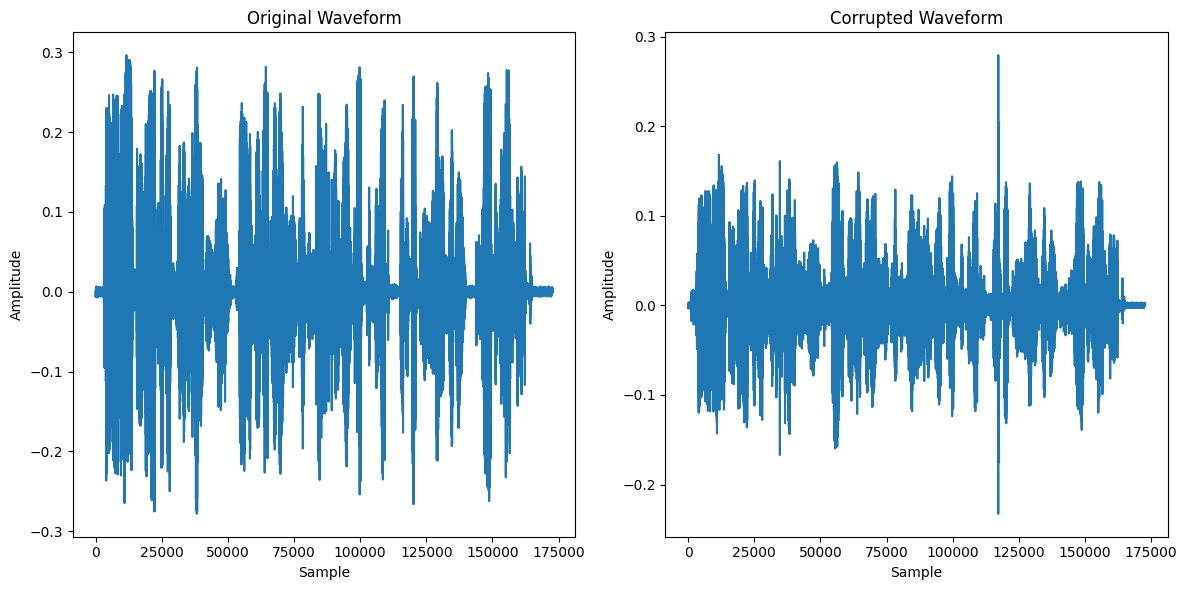

Original Audio:


In [ ]:
# Load the original audio file
filename_original = "/content/miniLibriSpeech/train-clean-100/19/198/19-198-0002.flac"
waveform_original, sample_rate_original = torchaudio.load(filename_original)

# Load the corrupted audio file
filename_corrupted = "/content/corruptednoises/train-clean-100/19/198/19-198-0002.flac"
waveform_corrupted, sample_rate_corrupted = torchaudio.load(filename_corrupted)

# Plot the original waveform
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(waveform_original.t().numpy())
plt.title('Original Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot the corrupted waveform
plt.subplot(1, 2, 2)
plt.plot(waveform_corrupted.t().numpy())
plt.title('Corrupted Waveform')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Listen to the original audio
print("Original Audio:")
Audio(waveform_original.numpy(), rate=sample_rate_original)

In [ ]:
# Listen to the corrupted audio
print("Corrupted Audio:")
Audio(waveform_corrupted.numpy(), rate=sample_rate_corrupted)

Corrupted Audio:


In [ ]:
## Todo: Merge speakers

# Prepare Overlaps

In [ ]:
def segment_audio(audio_path, output_folder, segment_info_list):
    # Load audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Calculate random segment duration between 1 and 2 seconds
    segment_duration = random.uniform(1, 2)

    # Calculate segment length in samples
    segment_length = int(segment_duration * sample_rate)

    # Extract file information
    file_path, file_name = os.path.split(audio_path)
    file_name, _ = os.path.splitext(file_name)
    speaker_id = file_name.split('-')[0]  # Extracting the speaker ID from the file name

    # Create output directory structure if not exists
    output_subfolder = os.path.join(output_folder, os.path.relpath(file_path, libri_root_path))
    os.makedirs(output_subfolder, exist_ok=True)

    # Iterate over the audio waveform and extract segments
    for i in range(0, waveform.size(1), segment_length):
        segment = waveform[:, i:i+segment_length]

        # Skip the last segment if it's shorter than segment_duration
        if segment.size(1) < segment_length:
            continue

        # Define output filename based on segment start time
        start_time = i / sample_rate
        output_filename = f"{file_name}-{start_time:.2f}-{start_time+segment_duration:.2f}.flac"
        output_path = os.path.join(output_subfolder, output_filename)

        # Save the segment as a separate audio file
        torchaudio.save(output_path, segment, sample_rate)

        # Add segment information to the list
        segment_info_list.append({
            "segment_length": segment_duration,
            "file_path": output_path,
            "speakerID": speaker_id
        })

# Find all FLAC files in the dataset
flac_files = glob.glob(os.path.join(os.path.join(libri_root_path, "train-clean-100"), "**/*.flac"), recursive=True)

# Initialize list to store segment information
all_segment_info = []

# Iterate over FLAC files and segment them
for audio_file in flac_files:
    segment_audio(audio_file, miniLibriSpeechSegments_path, all_segment_info)

# Write all segment information to a single JSON file
json_output_path = os.path.join(miniLibriSpeechSegments_path, "train-clean-100_segments.json")
with open(json_output_path, "w") as json_file:
    json.dump(all_segment_info, json_file, indent=4)

In [26]:
import torchaudio
import torch
import json

# Function to load audio segment
def load_audio(file_path):
    waveform, sample_rate = torchaudio.load(file_path)
    return waveform, sample_rate

# Function to mix audio segments
def mix_audio_segments(segments):
    # Find the length of the longest segment
    max_len = max(segment.size(1) for segment in segments)
    # Pad segments with zeros to match the length of the longest segment
    padded_segments = [torch.nn.functional.pad(segment, (0, max_len - segment.size(1))) for segment in segments]
    # Stack and sum the segments
    mixed = torch.stack(padded_segments).sum(dim=0)
    return mixed

# Function to save mixed audio segment
def save_audio(waveform, sample_rate, output_path):
    torchaudio.save(output_path, waveform, sample_rate)

# Function to merge and process audio segments
def merge_and_process(segments_info):
    segments = []
    speaker_info = {}
    for segment_info in segments_info:
        waveform, sample_rate = load_audio(segment_info["file_path"])
        segments.append(waveform)

        # Update speaker_info
        speaker_id = segment_info["speakerID"]
        if speaker_id in speaker_info:
            speaker_info[speaker_id].append({
                "start_time": 0.0,  # Assume start time as 0.0 for all segments
                "end_time": segment_info["segment_length"]
            })
        else:
            speaker_info[speaker_id] = [{
                "start_time": 0.0,  # Assume start time as 0.0 for all segments
                "end_time": segment_info["segment_length"]
            }]

    # Mix segments
    mixed_segment = mix_audio_segments(segments)
    output_path = "merged_segment.flac"
    save_audio(mixed_segment, sample_rate, output_path)

    return output_path, speaker_info

# Example segments info
segments_info = [
    {
        "segment_length": 1.950529088400471,
        "file_path": "/content/miniLibriSpeechSegments/train-clean-100/32/21625/32-21625-0000-0.00-1.91.flac",
        "speakerID": "32"
    },
    {
        "segment_length": 1.950529088400471,
        "file_path": "/content/miniLibriSpeechSegments/train-clean-100/26/495/26-495-0000-0.00-1.54.flac",
        "speakerID": "26"
    }
]

# Merge and process audio segments
merged_audio_path, speaker_info = merge_and_process(segments_info)

# Save speaker information to JSON file
output_json = {
    "overlapped_segmented_ID": "example_id",
    "len_of_overlapped_segment": len(segments_info),
    "overlapped_segment_path": merged_audio_path,
    "speaker_info": speaker_info
}

with open("speaker_info.json", "w") as json_file:
    json.dump(output_json, json_file, indent=4)

print("Merged audio saved to:", merged_audio_path)
print("Speaker information saved to speaker_info.json")


Merged audio saved to: merged_segment.flac
Speaker information saved to speaker_info.json


In [ ]:
filename_original = "/content/miniLibriSpeech/train-clean-100/19/198/19-198-0002.flac"
waveform_original, sample_rate_original = torchaudio.load(filename_original)
plt.plot(waveform_original.t().numpy())
plt.show()

In [ ]:
segments_info = [
    {
        "segment_length": 1.950529088400471,
        "file_path": "/content/miniLibriSpeechSegments/train-clean-100/32/21625/32-21625-0000-0.00-1.91.flac",
        "speakerID": "32"
    },
    {
        "segment_length": 1.950529088400471,
        "file_path": "/content/miniLibriSpeechSegments/train-clean-100/26/495/26-495-0000-0.00-1.54.flac",
        "speakerID": "26"
    }
]
